# The effects of lowering image resolution

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
%matplotlib inline

from IPython.display import display

PATH = os.path.abspath('../..')

# Plotting function

In [3]:
mad = lambda x: np.median(np.abs(x - np.median(x)))

def nmad(z, const=1.4826):
    """Returns the Gaussian sigma according to MAD"""
    return const*mad(z)

def rmse(z):
    """Returns the root mean squared error"""
    return np.sqrt(np.mean(z**2))

In [4]:
def plot_scatter(y_test, p_test, sz, ax, which_scatter, plot_style='scatter'):
    """Plot metallicity scatter for given resolution (image size, sz)"""
    
    bmin, bmax, step = 8.2, 9.3, 0.1

    y_bins = np.arange(bmin, bmax, step)
    num_in_bins = np.sum([(y_test > y - step/2) & (y_test < y + step/2) for y in y_bins], axis=1)

    if which_scatter == 'RMSE':
        rmse_bins = np.array([rmse((p_test - y_test)[(y_test > y - step/2) & (y_test < y + step/2)]) for y in y_bins])
        rmse_error = rmse(p_test - y_test)
        
        if plot_style == 'scatter':
            ax.scatter(y_bins, rmse_bins, marker='o', c='C0', s=num_in_bins/30, label=f'{sz:>3d} RMSE = {rmse_error:.4f}')
        elif plot_style == 'line':
            ax.plot(y_bins, rmse_bins, c=plt.cm.GnBu(np.log2(sz)/7 + 0.1), lw=3, label=f'{sz:>3d} RMSE = {rmse_error:.4f}')

    elif which_scatter == 'NMAD':
        nmad_bins = np.array([nmad(((p_test - y_test)[(y_test > y - step/2) & (y_test < y + step/2)])) for y in y_bins])
        nmad_error = nmad(p_test - y_test)
        # weighted nmad error
        #nmad_error = np.average(nmad_bins, weights=num_in_bins)
        if plot_style == 'scatter':
            ax.scatter(y_bins, nmad_bins, marker='o', c='C1', s=num_in_bins/30, label=f'{sz:>3d} NMAD = {nmad_error:.4f}')
        elif plot_style == 'line':
            ax.plot(y_bins, nmad_bins, c=plt.cm.autumn(np.log2(sz)/7 + 0.1), lw=3, label=f'{sz:>3d} NMAD = {nmad_error:.4f}')
    

# Testing the function

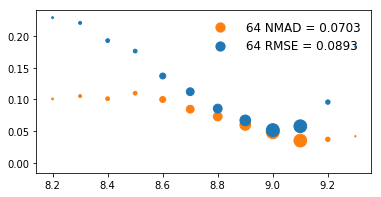

In [23]:
# get predictions
sz = 64
preds = pd.read_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv', index_col=0)
preds.head()


# make plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

plot_scatter(preds.oh_p50, preds.prediction, sz, ax, which_scatter='NMAD')
plot_scatter(preds.oh_p50, preds.prediction, sz, ax, which_scatter='RMSE')

# All resolutions

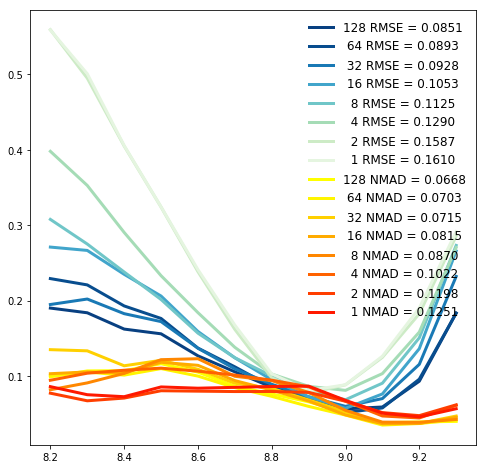

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for which_scatter in ['RMSE', 'NMAD']:
    sz = 128
    preds = pd.read_csv(f'{PATH}/catalogs/predictions-oh_p50.csv', index_col=0)
    plot_scatter(preds.oh_p50, preds.prediction, sz, ax, which_scatter=which_scatter, plot_style='line')
    for sz in [64, 32, 16, 8, 4, 2, 1]:
        preds = pd.read_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv', index_col=0)
        plot_scatter(preds.oh_p50, preds.prediction, sz, ax, which_scatter=which_scatter, plot_style='line')

ax.legend(fontsize=12, framealpha=0.0, frameon=False, loc='upper right')


# Scatter scaling with resolution

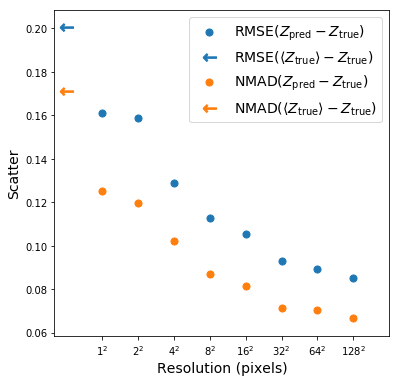

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))


# compute random scatter about median in total sample
intrinsic_rmse = rmse(preds.oh_p50 - np.mean(preds.oh_p50))
intrinsic_nmad = nmad(preds.oh_p50 - np.mean(preds.oh_p50))

sizes = [128, 64, 32, 16, 8, 4, 2, 1]
rmses = []
nmads = []
for sz in sizes:
    preds = pd.read_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv', index_col=0)
    
    rmses.append(rmse(preds.prediction - preds.oh_p50))
    nmads.append(nmad(preds.prediction - preds.oh_p50))
    
ax.scatter(sizes, rmses, c='C0', s=50, label=r'RMSE($Z_{\rm pred} - Z_{\rm true}$)')
ax.scatter(0.5, intrinsic_rmse, marker='$\u2190$', s=200, c='C0', label=r'RMSE($\langle Z_{\rm true}\rangle - Z_{\rm true}$)')
ax.scatter(sizes, nmads, c='C1', s=50, label=r'NMAD($Z_{\rm pred} - Z_{\rm true}$)')
ax.scatter(0.5, intrinsic_nmad, marker='$\u2190$', s=200, c='C1', label=r'NMAD($\langle Z_{\rm true}\rangle - Z_{\rm true}$)')

ax.set_xscale('log')
plt.minorticks_off()
ax.set_xticks(list(reversed(sizes)), minor=False)
ax.set_xticklabels(list(reversed([str(s) + r'$^2$' for s in sizes])))

ax.set_xlim(0.4, 256)
ax.set_xlabel('Resolution (pixels)', fontsize=14)
ax.set_ylabel('Scatter', fontsize=14)

ax.legend(fontsize=14);

fig.savefig(f'{PATH}/results/03-resolution.pdf')

The same thing, but on a log-log plot

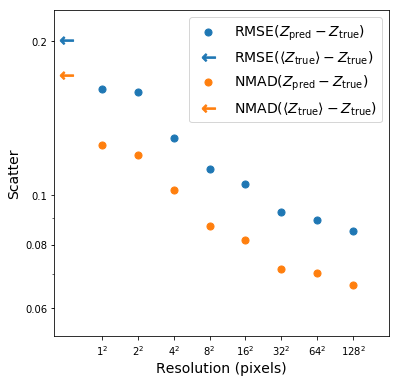

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sizes = [128, 64, 32, 16, 8, 4, 2, 1]
rmses = []
nmads = []
for sz in sizes:
    preds = pd.read_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv', index_col=0)
    
    rmses.append(rmse(preds.prediction - preds.oh_p50))
    nmads.append(nmad(preds.prediction - preds.oh_p50))
    
# compute random scatter about median in total sample
intrinsic_rmse = rmse(preds.oh_p50 - np.mean(preds.oh_p50))
intrinsic_nmad = nmad(preds.oh_p50 - np.mean(preds.oh_p50))

ax.scatter(sizes, rmses, c='C0', s=50, label=r'RMSE($Z_{\rm pred} - Z_{\rm true}$)')
ax.scatter(0.5, intrinsic_rmse, marker='$\u2190$', s=200, c='C0', label=r'RMSE($\langle Z_{\rm true}\rangle - Z_{\rm true}$)')
ax.scatter(sizes, nmads, c='C1', s=50, label=r'NMAD($Z_{\rm pred} - Z_{\rm true}$)')
ax.scatter(0.5, intrinsic_nmad, marker='$\u2190$', s=200, c='C1', label=r'NMAD($\langle Z_{\rm true}\rangle - Z_{\rm true}$)')


ax.set_xscale('log')
ax.minorticks_off()
ax.set_xticks(list(reversed(sizes)), minor=False)
ax.set_xticklabels(list(reversed([str(s) + r'$^2$' for s in sizes])))

ax.set_yscale('log')
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_yticks([.06, .08, 0.1, 0.2])
ax.set_yticklabels([.06, .08, 0.1, 0.2])

ax.set_xlim(0.4, 256)
ax.set_xlabel('Resolution (pixels)', fontsize=14)
ax.set_ylim(0.053, 0.23)
ax.set_ylabel('Scatter', fontsize=14)

ax.legend(fontsize=14);

#fig.savefig(f'{PATH}/results/03-resolution.pdf')

0.8538608065543263


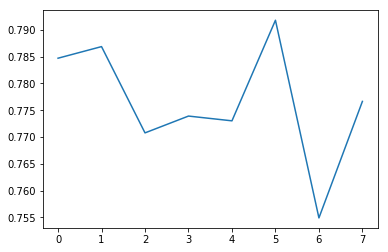

In [19]:
plt.plot(np.array(nmads) / np.array(rmses))

print(intrinsic_nmad / intrinsic_rmse)